In [397]:
import yaml

from roadvision3d.src.engine.dataloader import build_dataloader
from roadvision3d.src.datasets.kitti import KITTI

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import cv2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config and build dataloader

In [398]:
cfg_path = '/home/javier/pytorch/RoadVision3D/roadvision3d/configs/kitti.yaml'
cfg = yaml.load(open(cfg_path, 'r'), Loader=yaml.Loader)

train_loader, val_loader, test_loader = build_dataloader(cfg['dataset'])
dataset = KITTI(split='trainval', cfg=cfg['dataset'])



In [399]:
print(dataset.idx_list)

item = 8

['000000', '000001', '000002', '000003', '000004', '000005', '000006', '000007', '000008', '000009', '000010', '000011', '000012', '000013', '000014', '000015', '000016', '000017', '000018', '000019', '000020', '000021', '000022', '000023', '000024', '000025', '000026', '000027', '000028', '000029', '000030', '000031', '000032', '000033', '000034', '000035', '000036', '000037', '000038', '000039', '000040', '000041', '000042', '000043', '000044', '000045', '000046', '000047', '000048', '000049', '000050', '000051', '000052', '000053', '000054', '000055', '000056', '000057', '000058', '000059', '000060', '000061', '000062', '000063', '000064', '000065', '000066', '000067', '000068', '000069', '000070', '000071', '000072', '000073', '000074', '000075', '000076', '000077', '000078', '000079', '000080', '000081', '000082', '000083', '000084', '000085', '000086', '000087', '000088', '000089', '000090', '000091', '000092', '000093', '000094', '000095', '000096', '000097', '000098', '000099',

In [400]:
inputs, calib, coord_range, targets, info = dataset.__getitem__(item)
print(inputs.shape)

(3, 384, 1280)


In [401]:
print(targets.keys())

dict_keys(['depth', 'size_2d', 'heatmap', 'offset_2d', 'indices', 'size_3d', 'offset_3d', 'heading_bin', 'heading_res', 'cls_ids', 'mask_2d', 'vis_depth', 'rotation_y', 'position'])


In [402]:
valid_size_2d = targets['size_2d'][targets['mask_2d']==1]

print(targets['cls_ids'])
print(valid_size_2d)
print(targets['mask_2d'])

[0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[74.62801  49.752014]
 [31.77069  21.889862]
 [13.158142 10.202896]
 [18.52237  15.940739]]
[0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


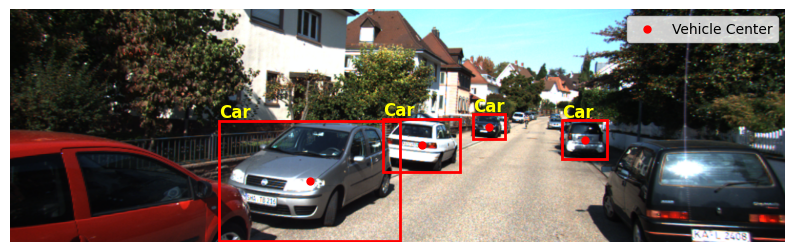

In [403]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_object_2d_bboxes_and_centers(inputs, targets, class_names=None):
    """
    Visualize the image and plot both the 2D bounding boxes, center points, and class names of the objects.
    inputs: Tensor (C, H, W)
    targets: Dictionary of target components
    class_names: Optional list of class names, corresponding to the class IDs (cls_ids) in targets.
    """

    # Denormalize the image (Assuming your dataset uses the mean and std defined earlier)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Convert from Tensor to NumPy
    img = inputs.transpose(1, 2, 0)  # C, H, W -> H, W, C
    img = (img * std + mean) * 255  # Denormalize
    img = img.astype(np.uint8)

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Extract valid objects
    valid_mask = targets['mask_2d'] == 1
    valid_indices = targets['indices'][valid_mask]
    valid_offset_2d = targets['offset_2d'][valid_mask]
    valid_size_2d = targets['size_2d'][valid_mask]  # Width and height of each box
    valid_cls_ids = targets['cls_ids'][valid_mask]  # Class IDs of valid objects

    # Default class names (if not provided)
    if class_names is None:
        class_names = ['Pedestrian', 'Car', 'Cyclist', 'Truck', 'Van', 'Other']

    # Calculate the center locations in the original image
    downsample_factor = 4
    feature_map_width = inputs.shape[2] // downsample_factor  # Width of the downsampled feature map

    centers_x = (valid_indices % feature_map_width) * downsample_factor + valid_offset_2d[:, 0] * downsample_factor
    centers_y = (valid_indices // feature_map_width) * downsample_factor + valid_offset_2d[:, 1] * downsample_factor

    # Scale up the size_2d to match the original image dimensions
    valid_size_2d *= downsample_factor

    # Draw bounding boxes, center points, and class labels for valid objects
    for i in range(len(valid_size_2d)):
        w, h = valid_size_2d[i]  # Scaled width and height of the object
        x_min = centers_x[i] - w / 2  # Top-left corner x
        y_min = centers_y[i] - h / 2  # Top-left corner y
        x_max = centers_x[i] + w / 2  # Bottom-right corner x
        y_max = centers_y[i] + h / 2  # Bottom-right corner y

        # Get the class name for this object
        cls_id = valid_cls_ids[i]
        class_name = class_names[cls_id]
        
        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), w, h, edgecolor='red', facecolor='none', linewidth=2))
        
        # Draw the center point
        plt.scatter(centers_x[i], centers_y[i], c='red', s=100, marker='.', label='Vehicle Center' if i == 0 else "")
        
        # Annotate with the class name
        plt.text(x_min, y_min - 5, class_name, color='yellow', fontsize=12, weight='bold')

    plt.legend()
    plt.axis('off')
    plt.show()

# Example usage
visualize_object_2d_bboxes_and_centers(inputs, targets)


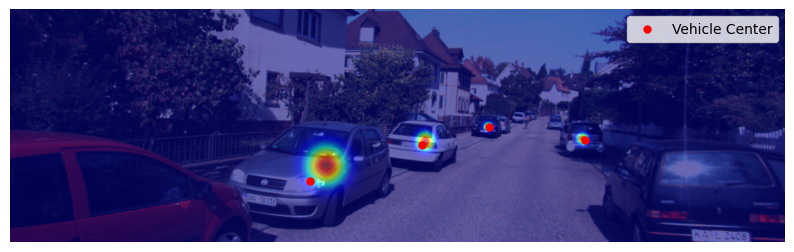

In [404]:
def visualize_heatmap_and_centers(inputs, targets, class_idx=1):
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = inputs.transpose(1, 2, 0)  # C, H, W -> H, W, C
    img = (img * std + mean) * 255  # Denormalize
    img = img.astype(np.uint8)

    # Extract and resize the heatmap
    heatmap = targets['heatmap'][class_idx]
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
    heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)

    # Blend the heatmap with the image
    alpha = 0.6
    blended = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

    # Compute center positions
    valid_mask = targets['mask_2d'] == 1
    valid_indices = targets['indices'][valid_mask]
    valid_offset_2d = targets['offset_2d'][valid_mask]

    downsample_factor = 4
    feature_map_width = inputs.shape[2] // downsample_factor

    # centers_x = ((valid_indices % feature_map_width) + valid_offset_2d[:, 0]) * downsample_factor
    # centers_y = ((valid_indices // feature_map_width) + valid_offset_2d[:, 1]) * downsample_factor

    centers_x = ((valid_indices % feature_map_width) + valid_offset_2d[:, 0]) * downsample_factor
    centers_y = ((valid_indices // feature_map_width) + valid_offset_2d[:, 1]) * downsample_factor

    # Plot the image with centers
    plt.figure(figsize=(10, 10))
    plt.imshow(blended)
    plt.scatter(centers_x, centers_y, c='red', s=100, marker='.', label='Vehicle Center')
    plt.legend()
    plt.axis('off')
    plt.show()


# Example usage:
visualize_heatmap_and_centers(inputs, targets, class_idx=1)


Object ID: 0
  Depth: 7.86 meters
  3D Size (width, height, length): 1.57, 1.50, 3.68
  Rotation Y (Yaw): 1.90 radians
  Heading Bin: 4, Heading Residual: -0.02
------------------------------------------------------------
Object ID: 1
  Depth: 14.44 meters
  3D Size (width, height, length): 1.47, 1.60, 3.66
  Rotation Y (Yaw): -1.25 radians
  Heading Bin: 9, Heading Residual: 0.25
------------------------------------------------------------
Object ID: 2
  Depth: 33.20 meters
  3D Size (width, height, length): 1.70, 1.63, 4.08
  Rotation Y (Yaw): 1.95 radians
  Heading Bin: 3, Heading Residual: 0.16
------------------------------------------------------------
Object ID: 3
  Depth: 19.96 meters
  3D Size (width, height, length): 1.59, 1.59, 2.47
  Rotation Y (Yaw): -1.25 radians
  Heading Bin: 9, Heading Residual: -0.09
------------------------------------------------------------


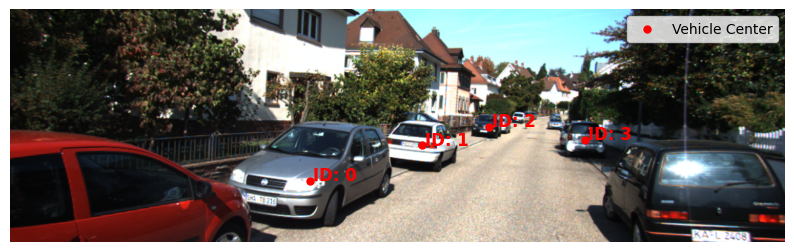

In [405]:
def visualize_vehicle_centers_dimensions_depth(inputs, targets, cfg, num_bins=12):
    """
    Visualize the image and plot the center points of the vehicles with their IDs on the image.
    Also, print the ID, depth, 3D dimensions, rotation_y, and heading_bin + heading_res in the console.
    Additionally, convert heading_bin and heading_res back into rotation_y for verification.
    inputs: Tensor (C, H, W)
    targets: Dictionary of target components
    cfg: Configuration that contains mean sizes for classes
    num_bins: Number of heading bins used (default is 12)
    """

    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = inputs.transpose(1, 2, 0)  # C, H, W -> H, W, C
    img = (img * std + mean) * 255  # Denormalize
    img = img.astype(np.uint8)

    # Compute center positions
    valid_mask = targets['mask_2d'] == 1
    valid_indices = targets['indices'][valid_mask]
    valid_offset_2d = targets['offset_2d'][valid_mask]
    valid_size_3d = targets['size_3d'][valid_mask]  # 3D width, height, and length
    valid_depth = targets['depth'][valid_mask]  # Depth of each object
    valid_cls_ids = targets['cls_ids'][valid_mask]  # Class IDs of valid objects
    valid_rotation_y = targets['rotation_y'][valid_mask]  # Rotation (yaw angle) of the vehicles
    valid_heading_bin = targets['heading_bin'][valid_mask]  # Heading bin for each object
    valid_heading_res = targets['heading_res'][valid_mask]  # Heading residual for each object

    downsample_factor = 4
    feature_map_width = inputs.shape[2] // downsample_factor

    centers_x = ((valid_indices % feature_map_width) + valid_offset_2d[:, 0]) * downsample_factor
    centers_y = ((valid_indices // feature_map_width) + valid_offset_2d[:, 1]) * downsample_factor

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Iterate through each object and plot the centers, bounding boxes, IDs, and print details
    for i in range(len(valid_size_3d)):
        # Extract the 3D size (width, height, length) and depth for each object
        w_3d, h_3d, l_3d = valid_size_3d[i] + cfg['dataset']['cls_mean_size'][valid_cls_ids[i]]  # Extract width, height, length
        depth = float(valid_depth[i])  # Ensure depth is a scalar, not an array
        rotation_y = float(valid_rotation_y[i])  # Extract yaw angle (rotation around the vertical axis)
        heading_bin = int(valid_heading_bin[i])  # Heading bin for the object
        heading_res = float(valid_heading_res[i])  # Residual within the bin

        # Convert heading_bin and heading_res back to rotation_y
        bin_size = (2 * np.pi) / num_bins  # Size of each bin in radians
        reconstructed_rotation_y = bin_size * heading_bin + heading_res

        # Plot the center point
        plt.scatter(centers_x[i], centers_y[i], c='red', s=100, marker='.', label='Vehicle Center' if i == 0 else "")

        # Annotate the object ID next to the center
        plt.text(centers_x[i] + 5, centers_y[i], f'ID: {i}', color='red', fontsize=12, weight='bold')

        # # Draw the rectangle to represent the 2D projection of the 3D bounding box (width and height)
        # x_min = centers_x[i] - w_3d / 2
        # y_min = centers_y[i] - h_3d / 2
        # rect = plt.Rectangle((x_min, y_min), w_3d, h_3d, linewidth=2, edgecolor='blue', facecolor='none')
        # plt.gca().add_patch(rect)

        # Print the object details (ID, depth, 3D dimensions, yaw angle, heading_bin, heading_res) in the console
        print(f'Object ID: {i}')
        print(f'  Depth: {depth:.2f} meters')
        print(f'  3D Size (width, height, length): {w_3d:.2f}, {h_3d:.2f}, {l_3d:.2f}')
        print(f'  Rotation Y (Yaw): {rotation_y:.2f} radians')
        print(f'  Heading Bin: {heading_bin}, Heading Residual: {heading_res:.2f}')
        print('-' * 60)

    plt.legend()
    plt.axis('off')
    plt.show()
# Example usage:
visualize_vehicle_centers_dimensions_depth(inputs, targets, cfg)

Object 0:
  Size 3D (h, w, l): [1.57000005 1.5        3.68000006]
  Position: [-1.17  1.65  7.86]
  Rotation Y (Yaw): 1.899999976158142
Object 1:
  Size 3D (h, w, l): [1.47000002 1.60000002 3.66000008]
  Position: [ 1.07  1.55 14.44]
  Rotation Y (Yaw): -1.25
Object 2:
  Size 3D (h, w, l): [1.70000004 1.63       4.07999991]
  Position: [ 7.24  1.55 33.2 ]
  Rotation Y (Yaw): 1.9500000476837158
Object 3:
  Size 3D (h, w, l): [1.59000003 1.59000003 2.47000006]
  Position: [ 8.48  1.75 19.96]
  Rotation Y (Yaw): -1.25


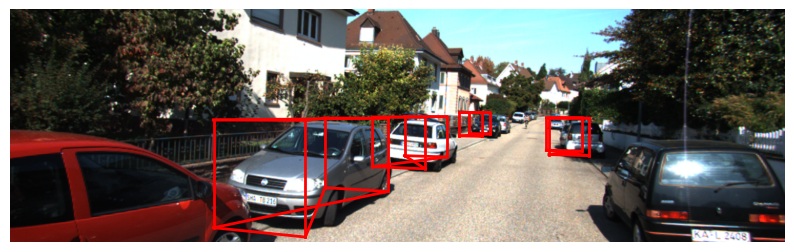

In [406]:
def project_to_image(pts_3d, P):
    # Add an extra column of ones to the 3D points for homogeneous coordinates
    pts_3d_homo = np.hstack((pts_3d, np.ones((pts_3d.shape[0], 1))))
    
    # Project 3D points to 2D using the camera matrix P
    pts_2d_homo = pts_3d_homo.dot(P.T)
    
    # Convert from homogeneous coordinates to 2D
    pts_2d = pts_2d_homo[:, :2] / pts_2d_homo[:, 2:3]
    
    return pts_2d

def compute_box_3d(dimensions, location, rotation_y):
    """
    dimensions: [h, w, l]
    location: [x, y, z] (bottom center of the object in camera coordinates)
    rotation_y: rotation around the y-axis (yaw)
    """
    h, w, l = dimensions
    x, y, z = location

    # Create rotation matrix around the y-axis
    R = np.array([
        [ np.cos(rotation_y), 0, np.sin(rotation_y)],
        [               0, 1,              0],
        [-np.sin(rotation_y), 0, np.cos(rotation_y)]
    ])

    # 3D bounding box corners in the object coordinate system
    x_corners = [ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2]
    y_corners = [    0,    0,     0,     0,    -h,    -h,    -h,    -h]
    z_corners = [ w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2,  w/2]

    # Stack corners and apply rotation
    corners_3d = np.dot(R, np.vstack([x_corners, y_corners, z_corners]))

    # Translate corners to the object's location
    corners_3d[0, :] += x
    corners_3d[1, :] += y
    corners_3d[2, :] += z

    return corners_3d.transpose()

def visualize_3d_bbox_on_image(inputs, targets, P, cfg):
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = inputs.transpose(1, 2, 0)
    img = (img * std + mean) * 255
    img = img.astype(np.uint8)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Extract valid objects
    valid_mask = targets['mask_2d'] == 1
    valid_size_3d = targets['size_3d'][valid_mask]
    valid_position = targets['position'][valid_mask]
    valid_rotation_y = targets['rotation_y'][valid_mask]
    valid_cls_ids = targets['cls_ids'][valid_mask]

    for i in range(len(valid_size_3d)):
        cls_id = valid_cls_ids[i]
        mean_size = cfg['dataset']['cls_mean_size'][cls_id]

        # Reconstruct actual 3D size [h, w, l]
        size_3d = valid_size_3d[i] + mean_size  # [h, w, l]
        h, w, l = size_3d

        # Get position without adjustment
        position = valid_position[i]  # [x, y, z]

        rotation_y = valid_rotation_y[i]

        print(f"Object {i}:")
        print(f"  Size 3D (h, w, l): {size_3d}")
        print(f"  Position: {position}")
        print(f"  Rotation Y (Yaw): {rotation_y}")

        # Compute the 3D corners of the bounding box
        corners_3d = compute_box_3d([h, w, l], position, rotation_y)

        # Project the 3D corners to 2D image plane
        corners_2d = project_to_image(corners_3d, P)

        # Define the edges of the bounding box
        edges = [
            (0, 1), (1, 5), (5, 4), (4, 0),  # Front face
            (2, 3), (3, 7), (7, 6), (6, 2),  # Back face
            (0, 2), (1, 3), (4, 6), (5, 7)   # Side edges
        ]

        # Draw the edges
        for edge in edges:
            x_coords = [corners_2d[edge[0], 0], corners_2d[edge[1], 0]]
            y_coords = [corners_2d[edge[0], 1], corners_2d[edge[1], 1]]
            plt.plot(x_coords, y_coords, color='red', linewidth=2)

    plt.axis('off')
    plt.show()

# Example usage:
visualize_3d_bbox_on_image(inputs, targets, calib, cfg)


In [407]:
from visualizer import draw_3d_bboxes
from roadvision3d.src.datasets.object_3d import Calibration, Object3d


random_flip


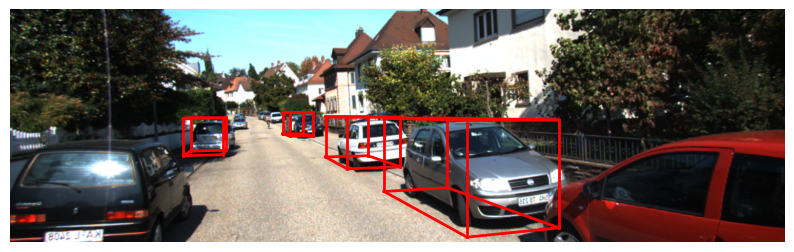

In [408]:

def targets_to_labels(targets, calib):
    # Extract valid objects
    valid_mask = targets['mask_2d'] == 1
    valid_size_3d = targets['size_3d'][valid_mask]
    valid_position = targets['position'][valid_mask]
    valid_rotation_y = targets['rotation_y'][valid_mask]
    valid_cls_ids = targets['cls_ids'][valid_mask]

    objects = []
    
    for i in range(len(valid_size_3d)):
        cls_id = valid_cls_ids[i]
        mean_size = cfg['dataset']['cls_mean_size'][cls_id]

        # Reconstruct actual 3D size [h, w, l]
        size_3d = valid_size_3d[i] + mean_size  # [h, w, l]
        h, w, l = size_3d

        # Get position without adjustment
        position = valid_position[i]  # [x, y, z]

        rotation_y = valid_rotation_y[i]

        # Create an Object3D instance
        alpha = None
        bbox2d = (0.0, 0.0, 0.0, 0.0)
        obj = Object3d(
            cls_type=cls_id,
            alpha=alpha,
            box2d=bbox2d,
            h=h,
            w=w,
            l=l,
            pos=position,
            ry=rotation_y
        )
        objects.append(obj)

    calib = Calibration(calib, None, None, None)  
    
    return objects, calib

def draw_3d_bboxes(inputs, object, calib):
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = inputs.transpose(1, 2, 0)  # C, H, W -> H, W, C
    img = (img * std + mean) * 255  # Denormalize
    img = img.astype(np.uint8)  # Convert to uint8 for displaying

    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Loop through all objects and project 3D bboxes to 2D
    for obj in object:
        # Get the 3D bbox (assuming obj has a method to generate corners in 3D)
        corners3d = obj.generate_corners3d()

        # Project the 3D bbox to the image using calibration
        corners2d, depths = calib.rect_to_img(corners3d)  # Project the corners into 2D

        # Ensure corners2d is a list of tuples, not an array of arrays
        corners2d = [tuple(coord) for coord in corners2d]

        # Connect the points: 0-1-2-3-0 (bottom face) and 4-5-6-7-4 (top face)
        bottom_face = [0, 1, 2, 3, 0]
        top_face = [4, 5, 6, 7, 4]
        vertical_edges = [(0, 4), (1, 5), (2, 6), (3, 7)]

        # Draw bottom and top faces
        for i in range(4):
            # Bottom face
            plt.plot([corners2d[bottom_face[i]][0], corners2d[bottom_face[i+1]][0]],
                     [corners2d[bottom_face[i]][1], corners2d[bottom_face[i+1]][1]], color='red', linewidth=2)
            # Top face
            plt.plot([corners2d[top_face[i]][0], corners2d[top_face[i+1]][0]],
                     [corners2d[top_face[i]][1], corners2d[top_face[i+1]][1]], color='red', linewidth=2)

        # Draw vertical edges connecting the top and bottom faces
        for edge in vertical_edges:
            plt.plot([corners2d[edge[0]][0], corners2d[edge[1]][0]],
                     [corners2d[edge[0]][1], corners2d[edge[1]][1]], color='red', linewidth=2)

    plt.axis('off')  # Turn off the axis numbers and ticks
    plt.show()

inputs, calib, coord_range, targets, info = dataset.__getitem__(item)

# Convert targets to Object3D instances
objects, calib2 = targets_to_labels(targets, calib)

draw_3d_bboxes(inputs, objects, calib2)
            

